# **AISaturdays Rental Challenge**

![AISaturdays](https://www.saturdays.ai/assets/images/ai-saturdays-122x122.png)

Bienvenido al reto de **AISaturdays** de Inteligencia Artificial para la predicción de precios de rentals de los barrios de una ciudad. En este ejercicio estimaremos el precio de una oferta de alquiler, dependiendo de unos datos descritos más abajo.

**Instrucciones:**

- Se usará el lenguaje de programación Python 3.
- Se usarán las librerías de python: Pandas, MatPlotLib, Numpy.

**Mediante este ejercicio, aprenderemos:**
- Entender y ejecutar los NoteBooks con Python.
- Ser capaz de utilizar funciones de Python y librerías adicionales.
- Dataset:
 - Obtener el dataset y previsualizar la información del dataset.
 - Limpiar y normalizar la información del dataset.
 - Representar y analizar la información del dataset.
- Aplicar el algoritmo de Random Forest
- Mejorar la predicción usando Hyperparameter Tunning, Feature engineering y Gradient Boosting

¡Empecemos!


#1.Importación de librerias 

In [6]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats

In [7]:
from sklearn.metrics import classification_report, plot_confusion_matrix, f1_score, accuracy_score

#2. Dataset

0. Lee el .csv con los datos y muestra las primeras filas.

In [8]:
alquiler = pd.read_csv('data.csv')
alquiler.head()

,Unnamed: 0,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price
0,35706,28341280,Bushwick Rustic Loft,10812370,Al,Brooklyn,Bushwick,40.69987,-73.91821,Private room,1,28,2019-07-07,2.75,1,36,69
1,2434,1213991,Private 2 bedroom Midtown Manhattan,6626827,Steve,Manhattan,Hell's Kitchen,40.76247,-73.99294,Private room,4,77,2019-06-19,1.81,1,21,240
2,44725,34372753,Spacious Manhattan Apartment,40038018,Yves,Manhattan,Midtown,40.76152,-73.97176,Entire home/apt,5,2,2019-06-09,1.00,1,132,449
3,32341,25311295,"★Modern,Cozy 3BDR/2BA Getaway in Upper East!",17896706,Mark,Manhattan,Upper East Side,40.77988,-73.95482,Entire home/apt,4,58,2019-06-18,4.26,1,158,399
4,9648,7411421,Hip & Trendy Williamsburg 2 BR 2BA Apartment,3750905,Louis,Brooklyn,Williamsburg,40.71303,-73.95580,Entire home/apt,2,28,2019-06-22,0.61,1,170,109


1. Muestra el numero de features y ejemplos en el dataset.

In [9]:
# Sólo con una línea de código
alquiler.shape

(32759, 17)

2. Obtén que tipos de datos (dtypes) contiene el dataset.

In [10]:
# Sólo con una línea de código
alquiler.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32759 entries, 0 to 32758
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      32759 non-null  int64  
 1   id                              32759 non-null  int64  
 2   name                            32755 non-null  object 
 3   host_id                         32759 non-null  int64  
 4   host_name                       32742 non-null  object 
 5   neighbourhood_group             32759 non-null  object 
 6   neighbourhood                   32759 non-null  object 
 7   latitude                        32759 non-null  float64
 8   longitude                       32759 non-null  float64
 9   room_type                       32759 non-null  object 
 10  minimum_nights                  32759 non-null  int64  
 11  number_of_reviews               32759 non-null  int64  
 12  last_review                     

### Variables



* **Id/name:**  Identificador y nombre de la oferta.

* **host_id/host_name:** Identificador y nombre del anfitrión.

* **neighbourhood_group/neighbourhood:** Zona y barrio de la oferta. Cada zona es una agrupación de barrios.
* **latitude/longitude:** Latitud y longitud de la oferta.

* **room_type:** Que tipo de habitación se oferta. Puede ser el apartamento o casa entero, una habitación privada o una compartida.

* **minimum_nights:**  Noches de estancia mínima.

* **number_of_reviews:**  Número total de reviews de la oferta.

* **last_review:**  Fecha de la última review hecha.

* **reviews_per_month:** Número de reviews por mes. No siempre es entero y la mayoría son menos de 1.

* **calculated_host_listings_count:** Cuantas habitaciones tiene el host en oferta.

* **availability_365:** La disponibilidad de la oferta en un año: máximo de 365 (todo el año en oferta)

* **price:** ¡Nuestro objetivo!. El precio de la oferta, en dolares.



¿Es este un problema de regression o de classification? ¿Por que?:

3. Antes de analizar el dataset, tenemos que transformar las fechas (la feature last_review) en algo con lo que podamos trabajar. Pandas tiene un data type específicamente para esto, datetime. Transforma last_review a formato datetime.

ESTAMOS ANTE UNA REGRESION

In [11]:
# Sólo con una línea de código
alquiler.last_review=pd.to_datetime(alquiler['last_review'])


4. Para analizar los datos también necesitamos saber cuanta información nos falta. Utiliza isnull() para averiguar a que feature le faltan mas datos. 

In [12]:
# Sólo con una línea de código
alquiler.isnull().sum()

Unnamed: 0                           0
id                                   0
name                                 4
host_id                              0
host_name                           17
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
minimum_nights                       0
number_of_reviews                    0
last_review                       6772
reviews_per_month                 6772
calculated_host_listings_count       0
availability_365                     0
price                                0
dtype: int64

5. Finalmente, solo nos falta deshacernos de las features que solo sirven de identificador y no ayudan a predecir.

In [13]:
# Sólo con una línea de código
rent = alquiler.copy()

In [14]:
rent = rent.drop(['name','host_name','Unnamed: 0','host_id','id'],axis=1)

6. ¡Todo listo! Ya podemos analizar la distribución de los datos con la función .describe()

In [15]:
# Sólo con una línea de código
rent.describe()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price
count,32759.000000,32759.000000,32759.000000,32759.000000,25987.000000,32759.000000,32759.000000,32759.000000
mean,40.728968,-73.952465,7.131475,23.240911,1.383150,7.223175,113.116090,154.312983
std,0.054479,0.045704,21.236959,44.354050,1.699714,33.275291,131.687842,256.571284
min,40.499790,-74.240840,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,40.690150,-73.983130,1.000000,1.000000,0.190000,1.000000,0.000000,69.000000
50%,40.723180,-73.955800,3.000000,5.000000,0.730000,1.000000,45.000000,107.000000
75%,40.763155,-73.936540,5.000000,24.000000,2.030000,2.000000,226.000000,178.000000
max,40.913060,-73.712990,1250.000000,607.000000,58.500000,327.000000,365.000000,10000.000000


### Limpiar y normalizar la información del dataset
![texto alternativo](https://i.imgur.com/8u4xTI7.png)

Este dataset contiene información incompleta que debemos rellenar para poder usarla a la hora de predecir el precio de las ofertas.
También tenemos que transformar last_review si queremos incluirla en la predicción (no podemos utilizar una fecha como input directamente).

Para esta limpieza usaremos varias funciones de Pandas. Aquí teneis una [pista](https://new.paradigmadigital.com/wp-content/uploads/2019/02/Pandas_cheatsheet.pdf).

7. Encuentra el número de ofertas que por no tener reviews no tienen información en las columnas de last_review y reviews_per_month.

In [16]:
# Sólo con una línea de código
print(rent['last_review'].isnull().sum())
print(rent['reviews_per_month'].isnull().sum())

6772
6772


8. Tenemos que completar esta información si no queremos eliminar el resto del ejemplo. Rellena todos los NaNs de las reviews_per_month con 0 (Completaremos la columna de last_review después).

In [17]:
# Sólo con una línea de código 
rent['reviews_per_month'].fillna(0,inplace=True)

In [18]:
print(rent['reviews_per_month'].isnull().sum())

0


9. Vamos a transformar la variable last_review. Es una fecha, lo cual nos hace dificil trabajar con ella. Vamos primero a completar los ejemplos que no tienen una última fecha. Reemplaza estos NaNs con la primera review histórica del dataset.

In [19]:
# Dos lineas de código 
min_date=min(rent['last_review'])
rent['last_review'].fillna(min_date,inplace=True)

10. Ahora que no tenemos valores vacios podemos cambiar la variable last_review a algo mas util. Buscamos que valores mas pequeños correspondan a reviews antiguas o que no hayan tenido ninguna, mientras que valores mas grandes correspondan a reviews mas recientes. 

Podemos utilizar la función toordinal() para hayar el número de dias que han transcurrido desde el dia 1 del año 1, pero esos siguen siendo números demasiado grandes que no siguen la distribución que buscamos.

Consigue que last_reviews pase a representar la cantidad de dias que han transcurrido desde que se hizo la primera review histórica. 

In [20]:
rent['last_review']=rent['last_review'] - min_date

In [21]:
# Solo una línea de código


11. Para visualizar la distribución de las fechas, genera una gráfica que muestre la variable last_reviews.

In [22]:
# Solo una línea de código
rent.last_review = rent.last_review.apply(lambda x: x.days)

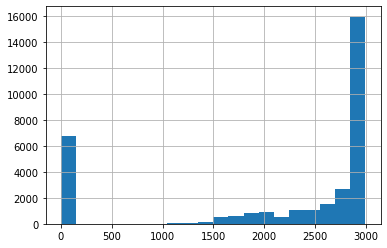

In [23]:
rent.last_review.hist(bins=20)

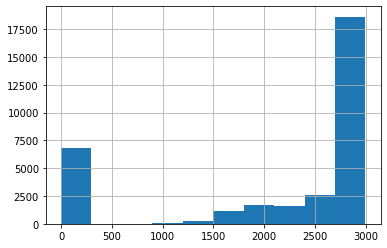

In [24]:
rent.last_review.hist()

Parece que hay dos grupos muy distinguidos. ¿A que se debe esta distribución?:

#### Estudio de la variable a predecir y eliminación de ruido

12. A la hora de predecir el precio, es mucho mas favorable si primero transformamos y analizamos la variable que buscamos para hacerla mas facil de predecir.

Primero, vamos a ver como el precio de las ofertas está distribuido. Genera una gráfica que muestre el precio de las ofertas. Aquí tienes una [Pista](https://seaborn.pydata.org/generated/seaborn.distplot.html).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


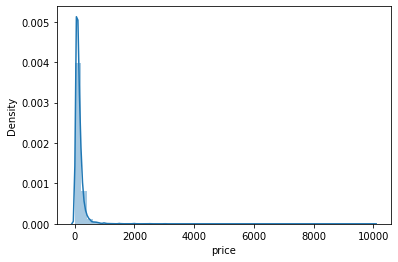

In [25]:
# Solo una línea de código.
sns.distplot(rent.price)

Tenemos una variable que sigue una distribución log-normal. Podemos transformarla en una distribución normal aplicando log1p(), una función que responde a la siguiente ecuación:

$ y = log(x+1) $

Esto hace que el precio sea mas facil de predecir, al tener una distribución normal.

13. Vamos a visualizar esta transformación. Genera otra gráfica de price tras aplicar la función log1p().

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


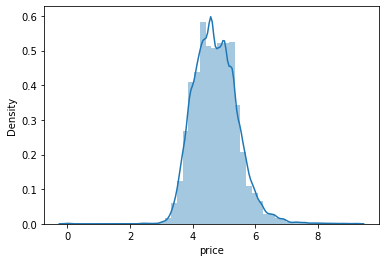

In [26]:
#Solo una línea de código
rent.price=np.log1p(rent.price)
sns.distplot(rent.price)


Ahora tenemos una distribución mucho mas apropiada para hacer predicciones. Sin embargo, todavía quedan muchos outliers que añaden ruido a la muestra.

14. ¿Por encima y debajo de qué valores esta presente este ruido?. Elimina del dataframe aquellos valores que no entren en la distribución normal.

In [27]:
#Dos lineas de código
rent=rent[(rent.price<6.5) & (rent.price>3)]


14. Ahora, vuelve a generar la gráfica de precio y log1p del precio (usa el mismo código que antes, o ponlo en un [subplot](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html)).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


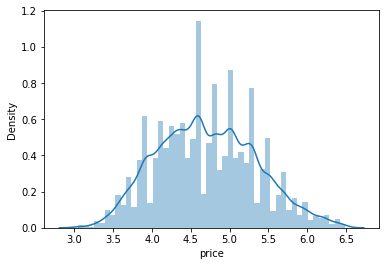

In [28]:
sns.distplot(rent.price)

15. Finalmente, tenemos una variable de salida normalizada y sin ruido que mejorará nuestras predicciones. Cambia la variable price por el log1p de price.


In [29]:
#Solo una línea de código
#HECHO MÁS ARRIBA

#### Exploración de variables


Vamos a explorar un poco mas el resto de variables que pueden afectar al precio de una oferta. 

16. Empecemos por crear un histograma de las distintas zonas de la ciudad y la cantidad de ofertas en cada una de ellas (a lo mejor necesitas ampliar el gráfico)

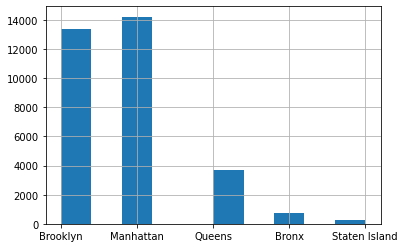

In [30]:
#Tres lineas de código
rent['neighbourhood_group'].hist()

17. Ahora crea un mapa de los apartamentos ofertados con la latitud y longitud (puntos extra si los coloreas por zonas o barrios). Lo mejor es hacerlo en un subplot y así puedes controlar el tamaño del mapa.

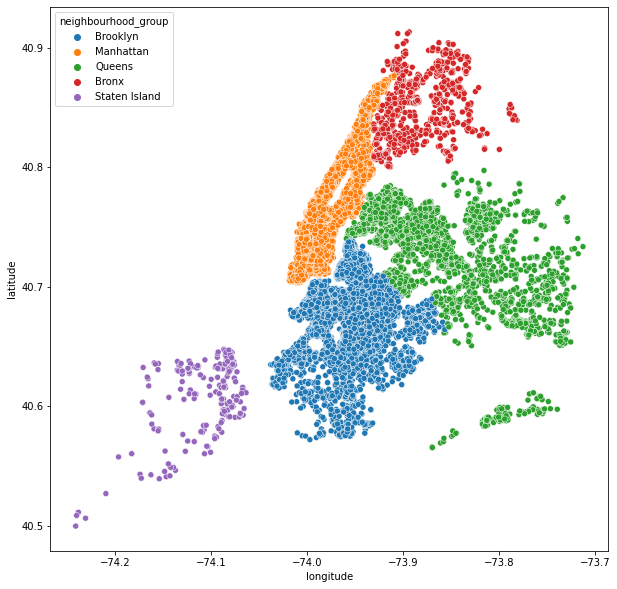

In [31]:
#Dos lineas de código
fig, ax = plt.subplots(figsize = (10, 10))
sns.scatterplot(x=rent['longitude'],y=rent['latitude'],hue=rent['neighbourhood_group'])

18. Vamos ahora a generar otro histograma, esta vez con el tipo de habitación ofertado (También es buena idea ajustar el tamaño de la gráfica).

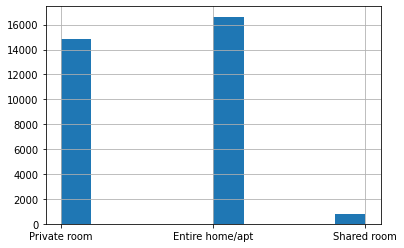

In [32]:
#Tres lineas de código
rent['room_type'].hist()

#### Transformación de variables

Podemos aplicar el mismo proceso que le aplicamos a la variable price a nuestras variables de entrada y así conseguir una distribución mas cómoda para los métodos de busqueda.

19. Aplica la transformación log1p() a minimum_nights, generando las gráficas antes y despues y compáralas. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


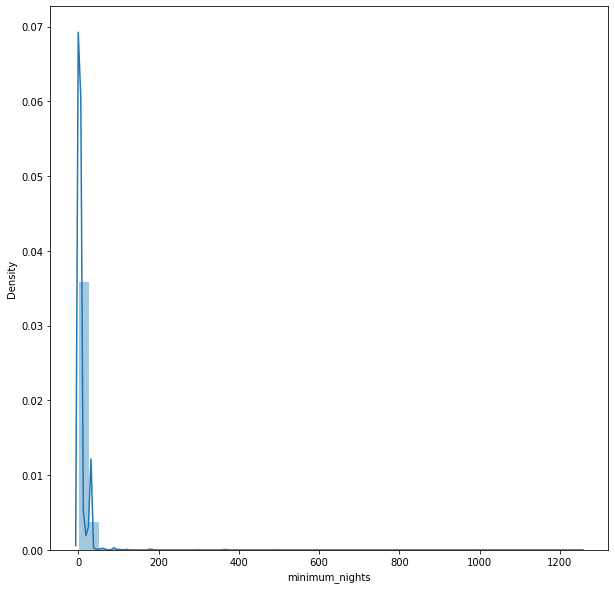

In [33]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.distplot(rent.minimum_nights)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


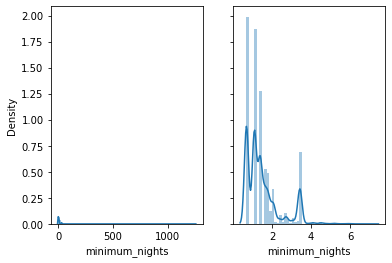

In [34]:
#Tres lineas de código
figure, axes = plt.subplots(1, 2,sharey=True)
sns.distplot(rent.minimum_nights,ax=axes[0])
sns.distplot(np.log1p(rent.minimum_nights),ax=axes[1])

20. Finalmente, guarda minimum_nights como log1p de minimum_nights

In [35]:
#Solo una línea de código.
rent.minimum_nights=np.log1p(rent.minimum_nights)

21. Repite el proceso, esta vez con reviews_per_month. ¿Es relevante la transformación?

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


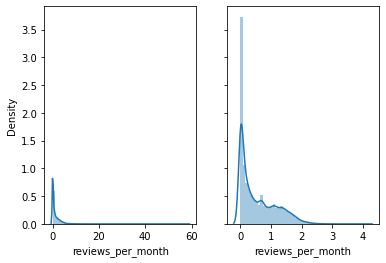

In [36]:
#Tres lineas de código.
figure, axes = plt.subplots(1, 2,sharey=True)
sns.distplot(rent.reviews_per_month,ax=axes[0])
sns.distplot(np.log1p(rent.reviews_per_month),ax=axes[1])

#### Estudio de la disponibilidad en número de dias (0,365)

22. Vamos a empezar representando la disponibilidad en un distplot(). Como conocemos los limites de esta variable, lo mejor es limitar el intervalo de la gráfica y hacerla mas grande.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


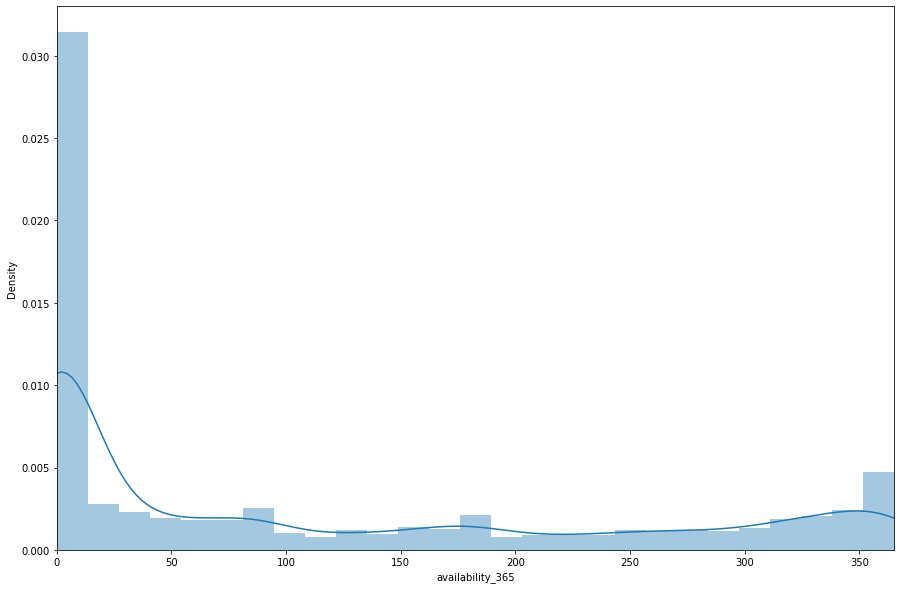

In [37]:
#Cuatro lineas de código.
fig, ax = plt.subplots(figsize = (15, 10))
plt.xlim(0,365)
sns.distplot(rent.availability_365)

#### Añadir variables artificiales

Se ha visto en el scatterplot anterior que parece haber dos grupos, uno disponible la mayor parte del año y otro solo unos pocos dias.

También se intuye que aquellos sitios que no tengan reviews... Como que no dan mucha confi no? ;)

23. Añade tres categorias que midan si el apartamento está disponible todo el año, si su disponibilidad es muy baja (menor de 12 dias al año), y si no tiene reviews.

In [38]:
#Tres lineas de código
rent['all_year']= (rent['availability_365'] == 365)
rent['less_12'] = (rent['availability_365'] < 12)
rent['no_reviews'] = (rent['number_of_reviews'] == 0)

24. Vamos a generar un heatmap que muestre la relación entre todas las variables de entrada y price. Utiliza corr() y la función heatmap() de seaborn.

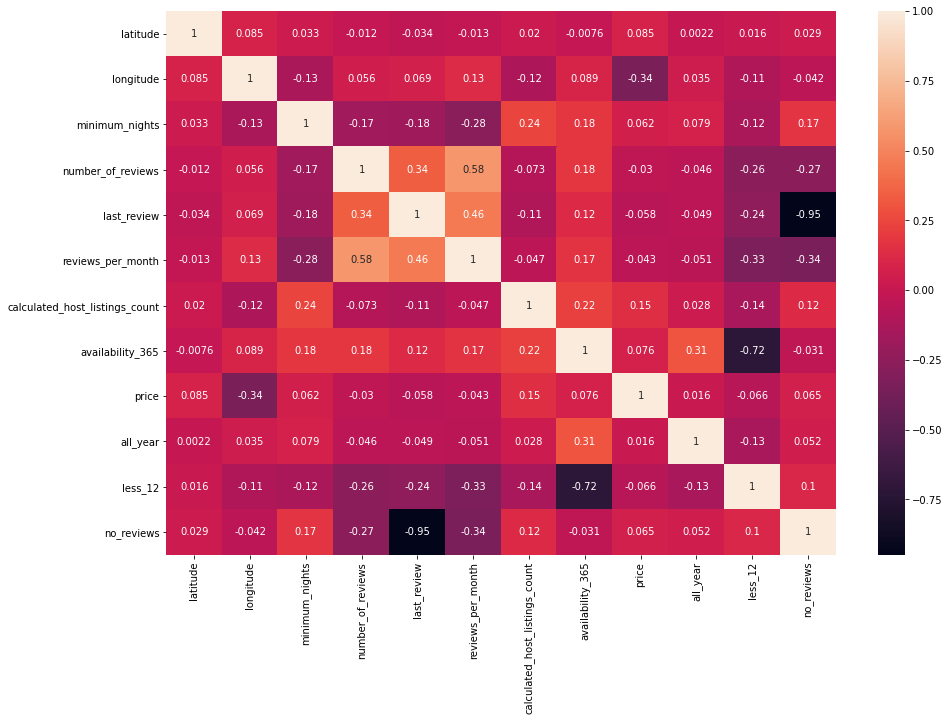

In [39]:
#Tres lineas de código
fig, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(rent.corr(),annot=True)

#### Pasar variables categóricas a one_hot


25. Para hacer las features categóricas mas fáciles de interpretar por el modelo, vamos a transformarlas en un OneHotEncoding. Utiliza la función get_dummies() de pandas (te deberían de quedar 241 columnas)

In [40]:
#Dos lineas de código
rent = pd.get_dummies(rent)

In [41]:
rent.head()

,latitude,longitude,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price,all_year,less_12,no_reviews,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Allerton,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,neighbourhood_Bath Beach,neighbourhood_Battery Park City,neighbourhood_Bay Ridge,neighbourhood_Bay Terrace,"neighbourhood_Bay Terrace, Staten Island",neighbourhood_Baychester,neighbourhood_Bayside,neighbourhood_Bayswater,neighbourhood_Bedford-Stuyvesant,neighbourhood_Belle Harbor,neighbourhood_Bellerose,neighbourhood_Belmont,neighbourhood_Bensonhurst,neighbourhood_Bergen Beach,neighbourhood_Boerum Hill,neighbourhood_Borough Park,neighbourhood_Breezy Point,neighbourhood_Briarwood,...,neighbourhood_South Ozone Park,neighbourhood_South Slope,neighbourhood_Springfield Gardens,neighbourhood_Spuyten Duyvil,neighbourhood_St. Albans,neighbourhood_St. George,neighbourhood_Stapleton,neighbourhood_Stuyvesant Town,neighbourhood_Sunnyside,neighbourhood_Sunset Park,neighbourhood_Theater District,neighbourhood_Throgs Neck,neighbourhood_Todt Hill,neighbourhood_Tompkinsville,neighbourhood_Tottenville,neighbourhood_Tremont,neighbourhood_Tribeca,neighbourhood_Two Bridges,neighbourhood_Unionport,neighbourhood_University Heights,neighbourhood_Upper East Side,neighbourhood_Upper West Side,neighbourhood_Van Nest,neighbourhood_Vinegar Hill,neighbourhood_Wakefield,neighbourhood_Washington Heights,neighbourhood_West Brighton,neighbourhood_West Village,neighbourhood_Westchester Square,neighbourhood_Westerleigh,neighbourhood_Whitestone,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,40.69987,-73.91821,0.693147,28,2995,2.75,1,36,4.248495,False,False,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,40.76247,-73.99294,1.609438,77,2977,1.81,1,21,5.484797,False,False,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,40.76152,-73.97176,1.791759,2,2967,1.00,1,132,6.109248,False,False,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,40.77988,-73.95482,1.609438,58,2976,4.26,1,158,5.991465,False,False,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,40.71303,-73.95580,1.098612,28,2980,0.61,1,170,4.700480,False,False,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


# Modelos, modelos, modelos

Hecha toda la exploración, análisis y limpieza de datos, pasamos a la parte divertida: ¡Los modelos!
    
Empezamos importando todas las clases que vamos a necesitar para encontrar un buen modelo predictivo:

In [42]:
from sklearn.model_selection import train_test_split,cross_val_score,  GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

26. Divide el dataset en X_train, X_test, y_train y y_test utilizando train_test_split(). No te olvides de no incluir price en el training set.

In [43]:
#Tres lineas de código
X = rent.drop('price', axis=1)
y = rent['price']
X_train, X_test, y_train , y_test = train_test_split(X , y , test_size=0.3 , random_state=42)

27. Vamos a utilizar cross_validation para entrenar nuesto modelo, utilizando Kfold para ha**y**ar la score. Implementa un Kfold que realize 5 splits y calcula el error medio y la desviación de un RandomForestRegressor sin cambiar sus parámetros (todavía). [Pista](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

In [44]:
#Tres lineas de código
scoring = "neg_mean_squared_error"
kf = KFold(n_splits = 5, random_state=42)
rnd_reg=RandomForestRegressor()
cross_val_score(rnd_reg, X_train, y_train, cv=kf, scoring=scoring)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


array([-0.15044151, -0.14316367, -0.1429556 , -0.1565884 , -0.15043104])

28. Al utilizar un RandomForestRegressor, ¿que hiperparámetros estabamos utilizando?. Lista todos los parámetros que utiliza este modelo (utiliza la función get_params() y la librería pprint)

In [45]:
from pprint import pprint
#Dos lineas de código
pprint(rnd_reg.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


Podemos ajustar todos estos paámetros para mejorar la exactitud de nuestro modelo. Una forma de encontrar qué combinación funciona mejor es utilizar un GridSearchCV, que prueba modelos con muchas combinaciones distintas y calcula su score para encontrar el mejor modelo a fuerza bruta. Para esto, hay que pasar una lista de valores para cada parámetro, y GridSearchCV probará con todos. [Mas información](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

29. Delimita que valores quieres que cada parámetro tenga, y incluye cada una de estas listas en un diccionario para poder ejecutar el GridSearchCV. Ten en cuenta los valores posibles para cada uno de los parámetros.

In [46]:
# 8 lineas de código
param_grid = {'max_depth': range(4, 8, 1), 
              'max_features': ['auto', 'sqrt','log2'], 
              'n_estimators': range(5, 200, 5),
              'min_samples_leaf':range(3,20,2)}

30. Ahora ya podemos implementar un GridSearchCV. Para hacerlo mas rápido, se utiliza una versión que no prueba con todas las combinaciones posibles, sino con unas cuantas de forma aleatorias.(de ahí su nombre, RandomizedSearchCV). Implementalo, teniendo en cuenta que tiene como parametros el modelo a ajustar y el diccionario que hemos definido antes, entre otros. Este paso puede durar unos minutos, ya que tiene que ajustar muchos modelos para encontrar el mejor. Aquí está la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) del RandomizedSearchCV.

In [47]:
#Dos lineas de código
clf = RandomizedSearchCV(rnd_reg, param_grid, random_state=42)
params = clf.fit(X_train, y_train).best_params_

31. Para terminar, encuentra el mean squared error y $R^2$ del mejor modelo que hallas creado. 

In [59]:
#Seis lineas de código
from sklearn.metrics import mean_squared_error
rfr = RandomForestRegressor(max_depth=7, max_features='auto',min_samples_leaf=3, n_estimators=65)
rfr.fit(X_train, y_train)
Y_predicted = rfr.predict(X_test)
print('mean squared error',mean_squared_error(y_test, Y_predicted))
print('r**2',rfr.score(X_test,y_test))

mean squared error 0.1682420101123024
r**2 0.5901164929333059


Ahora, ¡a mejorar esa score!
Puedes probar a:
- Eliminar features que no sean relevantes para la predicción
- Implementar Gradient boosting utilizando XBoost o Adaboost, entre otros
- Ajustar los hiperparámetros manualmente para llegar a mejores modelos
- Utilizar un Tree Interpreter para ver qué árboles de decisión tienen mas importancia

Al acabar el challenge, os daremos un validation set para ver que grupo ha conseguido la mejor score. ¡Quien gane tiene premio!

NORMALIZO LATITUD Y LONGITUD


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [ ]:
xgb = XGBClassifier(max_depth=6,learning_rate=0.25,n_estimators=100)
xgb.fit(X_train,y_train)

In [ ]:
y_pred=xgb.predict_proba(X_test)

In [ ]:
print('r**2',xgb.score(X_test,y_test))